In [1]:
import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np


CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import *
from src.utils.pre_processing.pre_processing import *
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS



material = openmc.Materials([FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, 
                             GRAPHITE_MATERIAL, STEEL_MATERIAL])
material.export_to_xml()

In [2]:
lattice_fuel = [ "f", "f", "f", "f", "h", "f", "f", "f", "f",
                 "f", "f", "f", "f", "f", "f", "f", "f", "f",
                 "f", "f", "h", "f", "f", "f", "f", "f", "f",
                 "f", "f", "f", "f", "f", "f", "f", "f", "f",
                 "f", "f", "f", "h", "f", "f", "f", "f", "f",
                 "f", "f", "f", "f", "f", "f", "h", "f", "f",
                 "f", "f", "f", "f", "f", "f", "f", "f", "f",
                 "f", "f", "f", "h", "h", "h", "h", "h", "h",
                 "h", "h", "h", "h", "h", "h", "h", "h", "h",
                 ]

# Replace strings with Universe objects
pin_fuel_cell = openmc.Cell(fill=FUEL_MATERIAL, region=-openmc.ZCylinder(r=1.))
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+openmc.ZCylinder(r=1.))
fuel_universe = openmc.Universe(cells=[pin_fuel_cell, graphite_cell], name="fuel_universe")


pin_helium_cell = openmc.Cell(fill=HELIUM_MATERIAL, region=-openmc.ZCylinder(r=1.))
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+openmc.ZCylinder(r=1.))
helium_universe = openmc.Universe(cells=[pin_helium_cell, graphite_cell], name="helium_universe")


In [3]:
all_graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL)

outer_universe = openmc.Universe(cells=(all_graphite_cell,))

lat_he_fuel = openmc.RectLattice(name="lattice_fuel")
lat_he_fuel.pitch = (4.5, 4.5)
lat_he_fuel.dimension = (np.sqrt(len(lattice_fuel)).astype(int), np.sqrt(len(lattice_fuel)).astype(int))
lat_he_fuel.lower_left = (-lat_he_fuel.pitch[0] * lat_he_fuel.dimension[0] / 2, -lat_he_fuel.pitch[1] * lat_he_fuel.dimension[1] / 2)
lat_he_fuel.universes = np.array([fuel_universe if x == "f" else helium_universe for x in lattice_fuel]).reshape(lat_he_fuel.dimension)
lat_he_fuel.outer = outer_universe

In [4]:
outer_surface = openmc.ZCylinder(r=30.)
height_top_active_part = openmc.ZPlane(z0=250.0)
height_bottom_active_part = openmc.ZPlane(z0=-250.0)

graphite_cell = openmc.Cell(
    fill=lat_he_fuel,
    region=(-outer_surface & -height_top_active_part & +height_bottom_active_part)
)

In [5]:
outer_sphere = openmc.Sphere(r=1000.0, boundary_type='vacuum')
air_region = -outer_sphere & ~graphite_cell.region
air_cell = openmc.Cell(fill=AIR_MATERIAL, region=air_region)

In [6]:
geometry = openmc.Geometry([graphite_cell, air_cell])
geometry.export_to_xml()

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 1
Plot file: plot_openmc_xy.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:  100  100
Coloring: Materials
Basis: XY
Pixels: 600 600

 Processing plot 1: plot_openmc_xy.png...


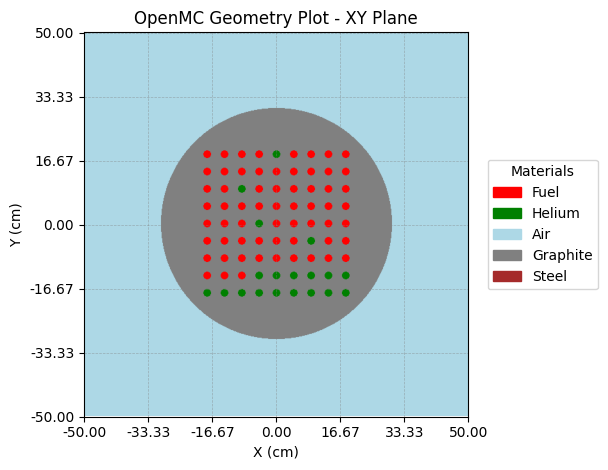

In [7]:
plot_geometry(materials = material, plane="xy", width=100, height=100, dpi=500, saving_figure=False, legend_materials=True)

 Reading materials XML file...
 Reading geometry XML file...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 2
Plot file: plot_openmc_yz.png
Universe depth: -1
Plot Type: Slice
Origin: 0 0 0
Width:  100  100
Coloring: Materials
Basis: YZ
Pixels: 600 600

 Processing plot 2: plot_openmc_yz.png...


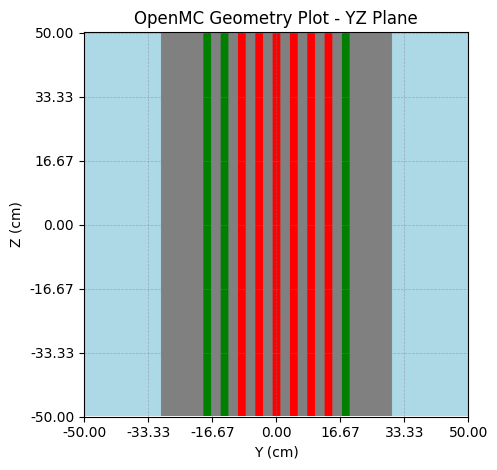

In [8]:
plot_geometry(materials = material, plane="yz", width=100, height=100, dpi=500, saving_figure=False)